In [1]:
import numpy as np
import pandas as pd


class DataLoaderPreprocessor:

    def __init__(self, base_dir='../../datasets/Movielens/', ml20m='ml-20m/', serendipity2018='serendipity-sac2018/'):
        self.ratings_df = None
        self.genome_scores_df = None
        self.movies_df = None

        self.movie_genre_binary_terms_df = None
        self.movies_lemmatized_genome_term_vector_df = None
        self.user_int_genre_terms_df = None
        self.user_genre_binary_term_vector_df = None
        self.user_lemmatized_genome_terms_df = None
        self.user_full_genome_terms_df = None

        self.base_dir = base_dir

        # dataset_dir
        self.ml20m = self.base_dir + ml20m
        self.serendipity2018 = base_dir + serendipity2018
        self.answers = serendipity2018 + 'answers.csv'

        self.data_output_dir = 'output/'

        self.dataset_files = {
            'ml20m': {
                'genome_scores': 'genome-scores.csv',
                'movies': 'movies.csv',
                'ratings': 'ratings.csv',

                'movie_genre_binary_terms': 'movie_genre_binary_term_vector_df_bz2',
                'user_int_genre_terms': 'user_int_terms_df_bz2',
                'user_genre_binary_terms': 'user_genre_binary_terms_df_bz2',
                'user_lemmatized_genome_terms': 'user_lemmatized_genome_terms_df_gzip',
                'user_full_genome_terms': 'user_full_genome_terms_df_gzip',
                'movies_genome_term_vector': 'movies_lemmatized_genome_vector_df_bz2'
            },
            'serendipity2018': {
                'genome_scores': 'tag_genome.csv',
                'movies': 'movies.csv',
                'ratings': 'training.csv',
                'answers': 'answers.csv'
            }
        }

        self.all_movie_ids = None

    def init_dataset(self, dataset):
        dataset_dir = None

        if dataset is 'serendipity2018':
            dataset_dir = self.base_dir + self.serendipity2018
        elif dataset is 'ml20m':
            dataset_dir = self.base_dir + self.ml20m

        return dataset_dir

    def init_file_names(self, dataset):
        dataset_dir = self.init_dataset(dataset)

        genome_scores = dataset_dir + self.dataset_files[dataset]['genome_scores']
        movies = dataset_dir + self.dataset_files[dataset]['movies']
        ratings = dataset_dir + self.dataset_files[dataset]['ratings']

        return genome_scores, movies, ratings

    def init_user_data_file_names(self, dataset):
        dataset_dir = self.init_dataset(dataset)

        movie_genre_binary_terms = dataset_dir + self.data_output_dir + self.dataset_files[dataset][
            'movie_genre_binary_terms']
        user_int_genre_terms = dataset_dir + self.data_output_dir + self.dataset_files[dataset]['user_int_genre_terms']
        user_genre_binary_terms = dataset_dir + self.data_output_dir + self.dataset_files[dataset][
            'user_genre_binary_terms']

        user_lemmatized_genome_terms = dataset_dir + self.data_output_dir + self.dataset_files[dataset][
            'user_lemmatized_genome_terms']
        user_full_genome_terms = dataset_dir + self.data_output_dir + self.dataset_files[dataset][
            'user_full_genome_terms']
        movies_genome_term_vector = dataset_dir + self.data_output_dir + self.dataset_files[dataset][
            'movies_genome_term_vector']

        return movie_genre_binary_terms, movies_genome_term_vector, user_int_genre_terms, user_genre_binary_terms, user_lemmatized_genome_terms, user_full_genome_terms

    def load_and_preprocess_data(self, dataset):
        print("\nLoading data: movies, ratings, genome-scores...")
        genome_scores, movies, ratings = self.init_file_names(dataset)

        # load all movies in df,
        self.movies_df = pd.read_csv(movies)

        # load tag-genome scores df
        self.genome_scores_df = pd.read_csv(genome_scores)
        self.genome_scores_df.columns = ['movieId', 'tagId', 'relevance']
        self.genome_scores_df = self.genome_scores_df.pivot(index='movieId', columns='tagId', values='relevance')

        # load all ratings
        self.ratings_df = pd.read_csv(ratings)

        print("Preprocessing data: movies, ratings, genome-scores...")

        # filter movies only under tag-genome df
        movies_with_tag_genome = self.genome_scores_df.index.values

        # filter-out movies with (no genres listed)
        no_genre_movies = self.movies_df[self.movies_df['genres'] == '(no genres listed)']['movieId'].unique()

        self.all_movie_ids = np.setdiff1d(movies_with_tag_genome, no_genre_movies)

        # store final list of movie ID's
        # udpate genome_scores_df, ratings_df and movies_df to only keep updated movie ID's
        self.ratings_df = self.ratings_df[self.ratings_df['movieId'].isin(self.all_movie_ids)]
        # self.genome_scores_df = self.genome_scores_df[self.genome_scores_df['movieId'].isin(self.all_movie_ids)]
        self.genome_scores_df = self.genome_scores_df.loc[self.all_movie_ids, :]
        self.movies_df = self.movies_df[self.movies_df['movieId'].isin(self.all_movie_ids)]

        return self.ratings_df, self.genome_scores_df, self.movies_df

    def load_and_process_user_data(self, dataset):
        print("\nLoading generated data: genre, genome-lemmatized, genome-full term vectors for users and movies...")

        if self.all_movie_ids is None:
            self.load_and_preprocess_data(dataset)

        movie_genre_binary_terms, movies_genome_term_vector, user_int_genre_terms, user_genre_binary_terms, user_lemmatized_genome_terms, user_full_genome_terms \
            = self.init_user_data_file_names(dataset)
        # TODO load

        print(
            "Preprocessing generated data: genre, genome-lemmatized, genome-full term vectors for users and movies...")

        self.movie_genre_binary_terms_df = pd.read_pickle(movie_genre_binary_terms, compression='bz2')
        self.user_int_genre_terms_df = pd.read_pickle(user_int_genre_terms, compression='bz2')
        self.user_lemmatized_genome_terms_df = pd.read_pickle(user_lemmatized_genome_terms, compression='gzip')
        self.user_full_genome_terms_df = pd.read_pickle(user_full_genome_terms, compression='gzip')
        self.movies_lemmatized_genome_term_vector_df = pd.read_pickle(movies_genome_term_vector, compression='bz2')
        self.user_genre_binary_term_vector_df = pd.read_pickle(user_genre_binary_terms, compression='bz2')

        # filter movies
        self.movies_lemmatized_genome_term_vector_df = self.movies_lemmatized_genome_term_vector_df.loc[
                                                       self.all_movie_ids, :]
        self.user_full_genome_terms_df = self.user_full_genome_terms_df.loc[self.all_movie_ids, :]
        self.movie_genre_binary_terms_df = self.movie_genre_binary_terms_df.loc[self.all_movie_ids, :]
        
        return self.movie_genre_binary_terms_df, self.movies_lemmatized_genome_term_vector_df, self.user_int_genre_terms_df, self.user_genre_binary_term_vector_df, self.user_lemmatized_genome_terms_df, self.user_full_genome_terms_df


In [10]:
from enum import Enum
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
#import DataLoaderPreprocessor
from time import time

data_base_dir = '../../datasets/Movielens/'
data_dir2 = data_base_dir + 'Movielens Latest/ml-latest/'
data_dir = data_base_dir + 'ml-20m/'
data_dir3 = data_base_dir + 'serendipity-sac2018/'
answers = data_dir3 + 'answers.csv'

data_output_dir = data_base_dir + 'output/'

genome_scores = data_dir + 'genome-scores.csv'
genome_tags = data_dir + 'genome-tags.csv'
movies = data_dir + 'movies.csv'
ratings = data_dir + 'ratings.csv'
tags = data_dir + 'tags.csv'
genres = data_dir + 'u.genre'

user_unstemmed_genome_vector = data_dir + 'user_unstemmed_genome_terms_df_gzip'
user_stemmed_genome_vector = data_dir + 'user_stemmed_genome_terms_df_gzip'


class BaselineRecommender_VectorType:
    # user binary terms, movie binary terms
    GENRE_BINARY = 1

    # user integer terms, movie binary terms
    GENRE_INTEGER = 2

    # user lemmatized terms, movie lemmatized terms
    GENOME_LEMMATIZED = 3

    # user full genome terms, movie full genome terms
    GENOME_FULL = 4


class ContentBased_Baseline_Recommender:
    # TODO recommend using genre binary term vector
    # TODO recommend using genre integer/float normalized term vector
    # TODO recommend using random K movie selection which are not amongst users watched list
    # TODO recommend using tag-genome term vector
    # TODO recommend using lemmatized tag-genome term vector

    def __init__(self, dataset='ml20m', movie_genre_binary_terms_df=None, movies_lemmatized_genome_term_vector_df=None,
                 user_int_genre_terms_df=None, user_genre_binary_term_vector_df=None,
                 user_lemmatized_genome_terms_df=None, user_full_genome_terms_df=None, ratings_df=None,
                 genome_scores_df=None, movies_df=None):
        self.dataset = dataset

        self.movies_genre_binary_term_vector_df = movie_genre_binary_terms_df
        self.movies_lemmatized_genome_vector_df = movies_lemmatized_genome_term_vector_df
        self.movies_full_genome_vector_df = genome_scores_df

        self.user_int_genre_terms_df = user_int_genre_terms_df
        self.user_genre_binary_term_vector_df = user_genre_binary_term_vector_df

        self.user_full_genome_terms_df = user_full_genome_terms_df
        self.user_lemmatized_genome_terms_df = user_lemmatized_genome_terms_df

        self.ratings_df = ratings_df
        self.movies_df = movies_df
        self.movie_average_ratings_df = None

        if self.ratings_df is not None:
            self.movie_average_ratings_df = self.ratings_df.loc[:, ['movieId', 'rating']].groupby('movieId').mean()

        # ml-20m setup
        # load all movies in df,
        # load tag-genome scores df
        # filter movies only under tag-genome df
        # filter-out movies with (no genres listed)
        # store final list of movie ID's
        # udpate genome_scores_df, ratings_df and movies_df to only keep updated movie ID's

    def load_all_data(self):
        data_loader = DataLoaderPreprocessor()
        self.ratings_df, self.movies_full_genome_vector_df, self.movies_df \
            = data_loader.load_and_preprocess_data(self.dataset)

        self.movies_genre_binary_term_vector_df, self.movies_lemmatized_genome_vector_df, self.user_int_genre_terms_df, \
        self.user_genre_binary_term_vector_df, self.user_lemmatized_genome_terms_df, self.user_full_genome_terms_df \
            = data_loader.load_and_process_user_data(self.dataset)

        self.movie_average_ratings_df = self.ratings_df.loc[:, ['movieId', 'rating']].groupby('movieId').mean()

    def get_vector_type_mapping(self, string_vector_type):
        """

        :param string_vector_type:
        :raises: ValueError if there's incorrect value in string_vector_type
        :return:
        """
        vector_types_dict = {
            'genre_binary': BaselineRecommender_VectorType.GENRE_BINARY,
            'genre_int': BaselineRecommender_VectorType.GENRE_INTEGER,
            'genome_lemmatized': BaselineRecommender_VectorType.GENOME_LEMMATIZED,
            'genome_full': BaselineRecommender_VectorType.GENOME_FULL
        }

        vector_type = vector_types_dict[string_vector_type]

        if vector_type is None:
            raise ValueError("%s is invalid argument, please read documentation for right choice of arguments")

        return vector_types_dict[vector_type]

    def recommend_k_most_similar_movies(self, user_id, K, vector_type=BaselineRecommender_VectorType.GENRE_BINARY):
        """

        :param K: Number of best similar movies to recommend
        :param vector_type: string {'genre_binary', 'genre_int', 'genome_lemmatized', 'genome_full'}or enum of type BaselineRecommender_VectorType,
         with possible values for enum being {GENRE_BINARY, GENRE_INTEGER, GENOME_LEMMATIZED, GENOME_FULL}
        :return:
        """
        if self.ratings_df is None:
            self.load_all_data()

        if type(vector_type) is str:
            vector_type = self.get_vector_type_mapping(vector_type)

        recommend_k_similar_movies = {
            BaselineRecommender_VectorType.GENRE_BINARY: self.user_binary_genre_based_recommendations(user_id, K),
            BaselineRecommender_VectorType.GENRE_INTEGER: self.user_integer_genre_based_recommendations(user_id, K),
            BaselineRecommender_VectorType.GENOME_FULL: self.user_full_genome_based_recommendations(user_id, K),
            BaselineRecommender_VectorType.GENOME_LEMMATIZED: self.user_lemmatized_genome_based_recommendations(user_id,
                                                                                                                K)
        }

        return recommend_k_similar_movies[vector_type].tolist()

    def user_binary_genre_based_recommendations(self, user_id, K):
        return self.genre_based_term_vec_recommendations(user_id, K, self.user_genre_binary_term_vector_df,
                                                         self.movies_genre_binary_term_vector_df)

    def user_integer_genre_based_recommendations(self, user_id, K):
        return self.genre_based_term_vec_recommendations(user_id, K, self.user_int_genre_terms_df,
                                                         self.movies_genre_binary_term_vector_df)

    def user_full_genome_based_recommendations(self, user_id, K):
        return self.genre_based_term_vec_recommendations(user_id, K, self.user_full_genome_terms_df,
                                                         self.movies_full_genome_vector_df)

    def user_lemmatized_genome_based_recommendations(self, user_id, K):
        return self.genre_based_term_vec_recommendations(user_id, K, self.user_lemmatized_genome_terms_df,
                                                         self.movies_lemmatized_genome_vector_df)

    def genre_based_term_vec_recommendations(self, user_id, K, user_term_vector_df, movies_term_vector_df):
        user_term_vector = user_term_vector_df.loc[user_id, :].values.reshape(1, -1)

        distances = pairwise_distances(user_term_vector, movies_term_vector_df.values,
                                       metric='cosine')

        nearest_movies_df = pd.DataFrame(index=movies_term_vector_df.index.values)
        nearest_movies_df['distances'] = distances.reshape(-1, 1)

        # ties in ranking are breaked based on average rating across all users
        nearest_movies_df['avg_rating'] = self.movie_average_ratings_df['rating']
        nearest_movies_df.sort_values(['distances', 'avg_rating'], ascending=False, inplace=True)

        return nearest_movies_df.index.values[:K]


# TODO create enum to allow selection between ranking algorithms
class RankingEnum:
    pass


class CB_ClusteringBased_Recommender:
    # TODO normalize values in ranking dataframe before reranking them.
    #   and compare results with non-normalized one
    # TODO p-median problem to infer user's taste based on tag-genomes.

    def __init__(self, ratings_df, genome_scores_df, user_term_vector_df, item_item_similarities_df, K=20,
                 n_neighbours=50, n_clusters=8, relevant_movies_threshold=0.2, random_state=171450):
        """

        :param ratings_df: Ratings df, original as read from Movielens dataset
        :param genome_scores_df: Genome scores dataframe,
            pivoted as index='movieId', columns='tagId', values='relevance'
        :param user_term_vector_df: Pandas Dataframe of User Genome Term Vector
        :param K: Recommend top K movies
        :param n_neighbours: Number of neighbor movies to consider for each candidate movie
        :param n_clusters: Number of clusters to be formed
        """
        self.ratings_df = ratings_df
        self.genome_scores_df = genome_scores_df
        self.user_term_vector_df = user_term_vector_df
        self.K = K
        self.n_neighbours = n_neighbours
        self.item_item_similarities_df = item_item_similarities_df
        self.relevant_movies_threshold = relevant_movies_threshold

        # Weighted ranking
        # TODO - remove hardcoding
        self.Rcu_weight = 0.40
        self.Su_weight = 0.20
        self.div_weight = 0.15
        self.Ci_weight = 0.15

        # TODO do all the necessary preprocessing under this method
        self.preprocess_data()

    def set_ranking_weights(self, Rcu_weight, Su_weight, div_weight, Ci_weight):
        self.Rcu_weight = Rcu_weight
        self.Su_weight = Su_weight
        self.div_weight = div_weight
        self.Ci_weight = Ci_weight

    def preprocess_data(self):
        # TODO choose movies only above threshold_rating
        # TODO omit movies without genres (no genres listed) - to compare with genre based approach
        pass

    def recommend_movies(self, user_id, K=None):
        # TODO choose movies only above threshold_rating
        # TODO omit movies without genres (no genres listed) - to compare with genre based approach
        if K is not None:
            self.K = K

        # extract list of movies watched by this user
        user_movies_d = self.get_users_watched_movies(user_id)

        # extract tag-genomes for movies watched by user
        user_movie_tags_df = self.genome_scores_df[self.genome_scores_df.index.isin(user_movies_d[user_id])]

        # create clusters_series for movies watched by user
        clusters_series = self.form_clusters(user_id, user_movies_d, user_movie_tags_df)

        # select right clusters_series to target:
        # TODO udpate optimal cluster selection technique
        target_clusters, cluster_ranks, above_mean_cluster_index, below_mean_cluster_index \
            = self.choose_appropriate_clusters_for_diversification(clusters_series)

        # decide ratio of movies selected from similar clusters to movies selected from sparse clusters
        N_movies_similar = int(self.K * self.relevant_movies_threshold)
        # TODO fix this, when K=8, this is being 0 for user ID 1 on ml20m dataset,
        #  failing only for full-genome df, not for lemmatized, check why not failing for lemmatized
        #   divide by zero error in some cases, unknown cases though
        N_movies_per_dense_cluster = int(N_movies_similar / above_mean_cluster_index.size)

        # existing greedy re-ranking approach for movies in sparse clusters
        N_movies_diverse = self.K - N_movies_similar

        # TODO figure out better way to remove duplicate movies from recommendations

        # RL1 - Recommendation List from Dense clusters
        dense_cluster_recommendations = list()

        # fetch n_neighbors for each movie in target_clusters
        previous_recommendations_count = N_movies_per_dense_cluster  # denotes number of movies recommended from previous cluster
        for cluster in above_mean_cluster_index:
            # find best K movies for each movie in a cluster
            # TODO rank according to highest diversity or decide best approach to re-rank these movies

            # movies from this cluster
            watched_movies = clusters_series[cluster]
            # if less movies are recommended from previous cluster(s), automatically recommend N extra movies
            N_movies = N_movies_per_dense_cluster + max(0, N_movies_per_dense_cluster - previous_recommendations_count)

            recommended_movies = self.find_similar_movies_to_dense_cluster(watched_movies, user_id, N_movies)
            dense_cluster_recommendations.extend(recommended_movies.tolist())

            # actual number of movies recommended from this cluster
            # difference indicates N movies yet to be recommended
            previous_recommendations_count = recommended_movies.size

        # In case if movies recommended form dense clusters are less than intended
        N_movies_diverse = N_movies_diverse + len(dense_cluster_recommendations) - N_movies_similar

        # greedy-re-ranking algorithm, based on rating, diversity, similarity to watched and user profile.
        # movies from this cluster
        # RL2 - Recommendation List from Sparse clusters
        sparse_cluster_recommendations = list()

        # get all watched movies from clusters below mean
        watched_movies = list()
        for cluster in below_mean_cluster_index:
            watched_movies.extend(clusters_series[cluster])

        sparse_cluster_recommendations.extend(
            self.find_similar_movies_to_sparse_cluster(watched_movies, user_id, N_movies_diverse, clusters_series))

        # rank similar movies for each cluster, and select top-N from each cluster
        # duplicate processing, keep one with the top cluster rank
        dense_cluster_recommendations.extend(sparse_cluster_recommendations)

        return dense_cluster_recommendations

    def find_similar_movies_to_sparse_cluster(self, watched_movies, user_id, N_movies_diverse, clusters_series):
        # TODO do experiment by changing R_cu to be average rating across all users rather than
        # TODO figure out better way to remove duplicate movies from recommendations
        # TODO test
        ranking_df = pd.DataFrame()

        for watched_movie_id in watched_movies:
            similar_movies = self.item_item_similarities_df[watched_movie_id].sort_values(ascending=False)[
                             :self.n_neighbours]

            similar_movies_df = pd.DataFrame(similar_movies)
            similar_movies_df['movieId'] = similar_movies_df.index
            similar_movies_df['watched_movie_id'] = similar_movies.name
            similar_movies_df.columns = ['S_c', 'movieId', 'watched_movie_id']

            similar_movies_df.reset_index(drop=True, inplace=True)

            ranking_df = ranking_df.append(similar_movies_df, ignore_index=True)

        movie_ids = ranking_df['movieId'].values

        # extract genome scores for movie_ids
        genome_scores_vector = self.user_term_vector_df.loc[movie_ids, :].values

        # extract user_term vector
        user_vector = self.user_term_vector_df.loc[user_id, :]

        distances_with_user = pairwise_distances(genome_scores_vector, [user_vector], metric='cosine')

        ranking_df['S_u'] = distances_with_user
        ranking_df['diversity'] = 1 - ranking_df['S_u']

        users_ratings = self.ratings_df[self.ratings_df['userId'] == user_id].loc[:, ['movieId', 'rating']]
        candidate_movie_ratings_df = users_ratings[users_ratings['movieId'].isin(watched_movies)]
        candidate_movie_ratings_df.set_index(candidate_movie_ratings_df['movieId'].values, drop=True, inplace=True)

        movie_ratings_dict = candidate_movie_ratings_df['rating'].to_dict()

        def assign_rating(x):
            x['R_cu'] = movie_ratings_dict[x['watched_movie_id']]

            return x

        ranking_df['R_cu'] = None

        ranking_df = ranking_df.apply(lambda x: assign_rating(x), axis=1)

        # add cluster rank as well, remove this line
        # ranks = ranking_df.loc[:, ['S_c', 'S_u', 'diversity', 'R_cu']].rank(method='dense')

        # cluster_size_df
        cluster_size_df = pd.DataFrame(index=clusters_series.index)

        def process(x):
            x['size'] = len(clusters_series[x.name])

            return x

        cluster_size_df['size'] = None
        cluster_size_df = cluster_size_df.apply(lambda x: process(x), axis=1)

        # smaller the cluster size, higher the score
        cluster_size_df['C_i'] = cluster_size_df.rank(method='dense', ascending=False).astype(np.int)

        def assign_cluster_score(x):
            x['C_i'] = self.get_movie_cluster_score(x['watched_movie_id'], clusters_series, cluster_size_df)
            return x

        ranking_df['C_i'] = None
        ranking_df = ranking_df.apply(lambda x: assign_cluster_score(x), axis=1)

        # ranking formula
        # The '\' sign indicates continuation of code from next line
        # TODO rework on this equation,
        #   consider something like (R_cu * rank(R_cu) + diversity * rank(diversity) + (S_u) * rank(S_u) + (S_c) * rank(S_c) + C_i
        # TODO ranking experiment-1
        # ranking_df['composite_score'] = ranking_df['R_cu'] * ranking_df['diversity'] \
        #                                 * ranking_df['S_u'] * ranking_df['S_c'] * ranking_df['C_i']
        #
        # sorted_scores_df = ranking_df.sort_values('composite_score', ascending=False)
        # sorted_scores_df.to_csv(data_output_dir + "ranking_composite1.csv")

        ranking_df['rank(R_cu)'] = ranking_df['R_cu'].rank(method='dense')
        ranking_df['rank(diversity)'] = ranking_df['diversity'].rank(method='dense')
        ranking_df['rank(S_u)'] = ranking_df['S_u'].rank(method='dense')
        ranking_df['rank(S_c)'] = ranking_df['S_c'].rank(method='dense')

        # TODO rework on this equation,
        #   consider something like (R_cu * rank(R_cu) + diversity * rank(diversity) + (S_u) * rank(S_u) + (S_c) * rank(S_c) + C_i
        # TODO check difference in df rank reordering with that from above formula
        # TODO ranking experiment-2
        # ranking_df['composite_score'] = ranking_df['R_cu'] * ranking_df['rank(R_cu)'] + ranking_df['diversity'] * \
        #                                 ranking_df['rank(diversity)'] \
        #                                 + ranking_df['S_u'] * ranking_df['rank(S_u)'] + ranking_df['S_c'] * ranking_df[
        #                                     'rank(S_c)'] + ranking_df['C_i']
        #
        # sorted_scores_df = ranking_df.sort_values('composite_score', ascending=False)
        # sorted_scores_df.to_csv(data_output_dir + "ranking_composite2.csv")
        #
        # # TODO ranking experiment-3:
        # ranking_df.drop(['composite_score', 'rank(R_cu)', 'rank(diversity)', 'rank(S_u)', 'rank(S_c)'], axis=1,
        #                 inplace=True)
        # exp3_df = ranking_df.sort_values(['S_c', 'S_u', 'diversity', 'R_cu', 'C_i'], ascending=False)
        # exp3_df.to_csv(data_output_dir + "ranking_composite3.csv")
        #
        # exp4_df = ranking_df.sort_values(['S_c', 'diversity', 'S_u', 'C_i', 'R_cu'], ascending=False)
        # exp3_df.to_csv(data_output_dir + "ranking_composite4.csv")
        #
        # print("Dataframes similarity:", exp3_df.equals(exp4_df))

        # TODO ranking experiment4:
        ranking_df['composite_score_weighted'] = self.Rcu_weight * ranking_df['rank(R_cu)'] \
                                                 + self.div_weight * ranking_df['rank(diversity)'] \
                                                 + self.Su_weight * ranking_df['rank(S_u)'] \
                                                 + self.Ci_weight * ranking_df['C_i']

        sorted_scores_df = ranking_df.sort_values('composite_score_weighted', ascending=False)

        # drop duplicates
        sorted_scores_df.set_index(sorted_scores_df['movieId'].values, drop=True, inplace=True)
        sorted_scores_df.drop(columns='movieId', inplace=True)
        sorted_scores_df['m_id'] = sorted_scores_df.index.values
        sorted_scores_df.drop_duplicates('m_id', inplace=True)
        sorted_scores_df.drop(columns='m_id', inplace=True)

        return sorted_scores_df.index.values[:N_movies_diverse].reshape(1, -1)[0]

    @staticmethod
    def get_movie_cluster_score(movieId, clusters_series, cluster_size_df):
        for cluster in clusters_series.index.tolist():
            if movieId in clusters_series[cluster]:
                return cluster_size_df.loc[cluster, ['C_i']].values[0]

        return 0

    def find_similar_movies_to_dense_cluster(self, watched_movies, user_id, N_movies_per_dense_cluster):
        # TODO figure out better way to remove duplicate movies from recommendations
        # TODO test
        ranking_df = pd.DataFrame()

        for watched_movie_id in watched_movies:
            # sort by most similar movies on top
            similar_movies = self.item_item_similarities_df[watched_movie_id].sort_values(ascending=False)[:self.K]

            similar_movies_df = pd.DataFrame(similar_movies)
            similar_movies_df['movieId'] = similar_movies_df.index
            # similar_movies_df['watched_movie_id'] = similar_movies.name
            similar_movies_df.columns = ['S_c', 'movieId']
            similar_movies_df.reset_index(drop=True, inplace=True)

            ranking_df = ranking_df.append(similar_movies_df, ignore_index=True)

        movie_ids = ranking_df['movieId'].values

        # extract genome scores for movie_ids
        genome_scores_vector = self.genome_scores_df.loc[movie_ids, :].values

        # extract user_term vector
        user_vector = self.user_term_vector_df.loc[user_id, :]

        distances_with_user = pairwise_distances(genome_scores_vector, [user_vector], metric='cosine')

        # similarity to user profile
        ranking_df['S_u'] = distances_with_user

        # diversity
        ranking_df['diversity'] = 1 - ranking_df['S_u']

        # sort as per highest diversity offered
        # TODO rethink on how to rerank these movies, whether by max diversity, or by similarity to watched_movie or similarity to user profile
        #   or whether multiple columns should be considered while ranking these movies
        ranking_df.sort_values('diversity', ascending=False, inplace=True)

        # TODO replace this approach with better way of dropping duplicates
        ranking_df.set_index(ranking_df['movieId'].values, drop=True, inplace=True)
        ranking_df.drop(columns='movieId', inplace=True)
        ranking_df['m_id'] = ranking_df.index.values
        ranking_df.drop_duplicates('m_id', inplace=True)
        ranking_df.drop(columns='m_id', inplace=True)

        return ranking_df.index.values[:N_movies_per_dense_cluster].reshape(1, -1)[0]

    def fetch_n_neighbors_for_target_clusters(self, target_clusters, all_cluster):
        """

        :param target_clusters:
        :param all_clusters: original all_clusters series
        :return:
        """
        # list all movie id's from target clusters:
        all_candidate_movies = list()

        for cluster in target_clusters:
            all_candidate_movies.extend(all_cluster[cluster].values.tolist())

    def fetch_N_similar_movies(self, candidate_movie_id):
        """
        :param candidate_movie_id:
        :return: Pandas Series with movieId as Index and relevance score to candidate movie as values
        """
        return self.item_item_similarities_df[candidate_movie_id].sort_values(ascending=False)[:self.n_neighbours]

    def choose_appropriate_clusters_for_diversification(self, clusters):
        """
        Choose appropriate cluster to do diversification
        :param clusters:
        :return:Array of cluster number below threshold,
                and
                Array of their respective ranks
        """
        cluster_size_df = pd.DataFrame(index=clusters.index)

        def process(x):
            x['size'] = len(clusters[x.name])

            return x

        cluster_size_df['size'] = None

        # calculate & store size for each cluster
        cluster_size_df.apply(lambda x: process(x), axis=1)

        # choose clusters with only up to median sizes
        # choosing all clusters
        below_mean_clusters_df = cluster_size_df[cluster_size_df['size'] <= cluster_size_df['size'].mean()]
        below_mean_cluster_index = below_mean_clusters_df.index.values

        above_mean_cluster_index = np.setdiff1d(cluster_size_df.index.values, below_mean_cluster_index)

        # rank clusters
        cluster_size_df['rank'] = cluster_size_df.rank(method='dense')

        return cluster_size_df.index.values, cluster_size_df[
            'rank'].values, above_mean_cluster_index, below_mean_cluster_index

    def form_clusters(self, user_id, user_movies_d, user_movie_tags_df):
        # TODO filter movies only above certain rating threshold
        n_movies = user_movie_tags_df.index.size
        highest_score = 0

        best_clustering_result = None

        # exhaustively check silhouette scores for each cluster sizes and select the cluster size with the highest score.
        for cluster_size in range(2, n_movies - 1, 1):
            clustering_result = AgglomerativeClustering(n_clusters=cluster_size, affinity='euclidean',
                                                        linkage='ward').fit_predict(
                user_movie_tags_df.values[:n_movies])
            score = silhouette_score(user_movie_tags_df.values[:n_movies], clustering_result)

            if highest_score < score:
                best_clustering_result = clustering_result
                highest_score = score

        new_df = pd.DataFrame(best_clustering_result, columns=['cluster'])

        new_df['movie'] = user_movies_d[user_id]
        resulting_clusters = new_df.groupby('cluster')['movie'].apply(list)

        return resulting_clusters

    def get_users_watched_movies(self, user_id):
        user_movies_d = {}

        user_movies_d[user_id] = self.ratings_df[self.ratings_df['userId'] == user_id]['movieId'].values.tolist()

        return user_movies_d


def top_K_similar_movies(user_id, K, all_movies_vector, user_genome_vector_df, genome_scores_df):
    all_movies_vector = genome_scores_df.values

    user_vector = user_genome_vector_df.loc[user_id, :].values

    # convert from 1D to 2D array
    user_vector = np.array([user_vector])

    distances = pairwise_distances(all_movies_vector, user_vector, metric='cosine')

    # 2D to 1D
    distances = distances.T[0]

    ser = pd.Series(distances, name=user_id)
    ser.index = genome_scores_df.index

    # top K recommendations, with relevance scores to the user profile
    return ser.sort_values(ascending=False)[:K]


def main():
    user_genome_vector_df = pd.read_pickle(user_unstemmed_genome_vector, compression='gzip')
    print(user_genome_vector_df.head())

    user_terms = user_genome_vector_df.values
    # chunked_D = pairwise_distances_chunked(user_terms, metric='cosine')

    genome_scores_df = pd.read_csv(genome_scores)
    genome_scores_df = genome_scores_df.pivot(index='movieId', columns='tagId', values='relevance')
    # genome_score_movies = genome_scores_df['movieId'].unique()
    genome_score_movies = genome_scores_df.index.unique().values

    ratings_df = pd.read_csv(ratings, usecols=range(3),
                             dtype={'userId': np.int64, 'movieId': np.int64, 'rating': np.float64}, low_memory=False)
    # only keep ratings for which the genome scores exists
    ratings_df = ratings_df[ratings_df['movieId'].isin(genome_score_movies)]

    item_terms = genome_scores_df.values
    user_terms = user_genome_vector_df.values

    item_terms = genome_scores_df.values
    item_item_distances = pairwise_distances(item_terms, metric='cosine')
    item_item_similarity_df = pd.DataFrame(item_item_distances, index=genome_scores_df.index,
                                           columns=genome_scores_df.index)
    print(item_item_distances)

    # recommender = ContentBased_Baseline_Recommender()
    recommender = CB_ClusteringBased_Recommender(ratings_df, genome_scores_df, user_genome_vector_df,
                                                 item_item_similarity_df, n_neighbours=8)
    # predict ratings for all users in serendipity dataset
    start_time = time()
    for user_id in range(1, 6):
        print(user_id)
        recommended_movies = recommender.recommend_movies(user_id)
        print(recommended_movies)
    finish_time = time() - start_time

    print("Total Time Taken: %f seconds" % finish_time)

    # load df from answers
    # answers_df = pd.read_csv(answers)
    # user_list = answers_df['userId'].unique().tolist()

    # final_recommendations_df = pd.DataFrame(columns=['userId', 'movieId'])
    #
    # for user_id in user_list[:5]:
    #     # predict ratings for all users in serendipity dataset
    #     recommended_movies = recommender.recommend_movies(user_id, K=8)
    #
    #     recommendations_df = pd.DataFrame(index=range(1, 9))
    #     recommendations_df['userId'] = user_id
    #     recommendations_df['movieId'] = recommended_movies
    #
    #     print(recommended_movies)
    #     final_recommendations_df = final_recommendations_df.append(recommendations_df, ignore_index=True)
    #
    # final_recommendations_df.to_csv(data_output_dir + "final_recommendations.csv")
    # print(final_recommendations_df)


# if __name__ == '__main__':
#     main()


In [11]:
# class Serendipity
import numpy as np
from enum import Enum
import pandas as pd
# import CB_ClusteringBased_Recommender, ContentBased_Baseline_Recommender, \
#     BaselineRecommender_VectorType
# from DataLoaderPreprocessor import DataLoaderPreprocessor
from sklearn.metrics import pairwise_distances

base_dir = '../../datasets/Movielens/'

ml20m = base_dir + 'ml-20m/'
serendipity2018 = base_dir + 'serendipity-sac2018/'

data_dir2 = serendipity2018
answers = serendipity2018 + 'answers.csv'

data_output_dir = base_dir + 'output/'


def evaluate_recommendations(user_id, recommendation_list, N_size, movie_genome_scores_df, user_genome_terms_df):
    movie_genomes_df = movie_genome_scores_df.loc[recommendation_list, :]
    user_vector_df = user_genome_terms_df.loc[user_id, :].values.reshape(1, -1)

    model_pairwise_scores_df = pd.DataFrame(index=recommendation_list)
    model_pairwise_scores_df['similarity'] = pairwise_distances(user_vector_df, movie_genomes_df.values,
                                                                metric='cosine').reshape(-1, 1)
    model_pairwise_scores_df['diversity'] = 1 - model_pairwise_scores_df['similarity']

    all_movies = model_pairwise_scores_df.index.values
    movie_genomes_df = movie_genome_scores_df.loc[all_movies, :]

    # calculating diversity of a list (1-SIM_ij)
    intra_list_distances_df = pd.DataFrame(
        1 - pairwise_distances(movie_genomes_df.values, movie_genomes_df.values, metric='cosine'), index=all_movies,
        columns=all_movies)
    diversity_of_list = intra_list_distances_df.sum(axis=1).sum() * (1 / (N_size * (N_size - 1)))
    similarity_of_list = 1 - diversity_of_list

    average_similarity = model_pairwise_scores_df['similarity'].mean()
    average_diversity = model_pairwise_scores_df['diversity'].mean()

    print("diversity_of_list: ", diversity_of_list)
    print("similarity_of_list: ", similarity_of_list)
    print("average_diversity: ", average_diversity)
    print("average_similarity: ", average_similarity)

    return diversity_of_list, similarity_of_list, average_diversity, average_similarity


def evaluate_all_models(experimental_users_list, result_dict, N_recommendations):
    for user_id in experimental_users_list:
        for model in result_dict:
            evaluation_result = evaluate_recommendations(user_id, main_model_lemmatized, N_recommendations, movie_lemmatized_genome_scores_df,
                                     user_lemmatized_genome_vector_df)


def update_recommendation_results_dict(recommendation_results_dict, recommendation_list, key):
    previous_recommendations_list = recommendation_results_dict[key.name]
    previous_recommendations_list.append(recommendation_list)
    recommendation_results_dict[key.name] = previous_recommendations_list


class Model(Enum):
    main_model_lemmatized = 'main_model_lemmatized'
    main_model_full = 'main_model_full'
    baseline_genre_binary = 'baseline_genre_binary'
    baseline_genre_int = 'baseline_genre_int'
    baseline_genome_lemmatized = 'baseline_genome_lemmatized'
    baseline_genome_full = 'baseline_genome_full'


def get_vector_type(baseline_model):
    model_to_vector_dict = {
        Model.baseline_genre_binary: BaselineRecommender_VectorType.GENRE_BINARY,
        Model.baseline_genre_int: BaselineRecommender_VectorType.GENRE_INTEGER,
        Model.baseline_genome_lemmatized: BaselineRecommender_VectorType.GENOME_LEMMATIZED,
        Model.baseline_genome_full: BaselineRecommender_VectorType.GENOME_FULL
    }

    return model_to_vector_dict[baseline_model]


# def main():
dataset = 'ml20m'
data_loader = DataLoaderPreprocessor(base_dir=base_dir, ml20m='ml-20m/',
                                     serendipity2018='serendipity-sac2018/')
ratings_df, genome_scores_df, movies_df = data_loader.load_and_preprocess_data(dataset)

movie_genre_binary_terms_df, movies_lemmatized_genome_term_vector_df, \
user_int_genre_terms_df, user_genre_binary_term_vector_df, user_lemmatized_genome_terms_df, user_full_genome_terms_df \
    = data_loader.load_and_process_user_data(dataset)

# movie_genre_binary_terms_df, movies_genome_term_vector_df, user_int_genre_terms_df,\
# user_lemmatized_genome_terms_df, user_full_genome_terms_df \

user_id = 1
K = 20

recommendation_results_dict = {
    'main_model_lemmatized': list(),
    'main_model_full': list(),
    'baseline_genre_binary': list(),
    'baseline_genre_int': list(),
    'baseline_genome_lemmatized': list(),
    'baseline_genome_full': list()
}

baseline_models = [Model.baseline_genre_binary, Model.baseline_genre_int, Model.baseline_genome_lemmatized,
                   Model.baseline_genome_full]

experimental_users_list = range(1, 20)
experimental_users_list = [9, 10, 11, 12, 13, 14]

for user_id in experimental_users_list:
    item_terms = movies_lemmatized_genome_term_vector_df.values
    item_item_distances = pairwise_distances(item_terms, metric='cosine')
    item_item_similarity_df = pd.DataFrame(item_item_distances, index=movies_lemmatized_genome_term_vector_df.index,
                                           columns=movies_lemmatized_genome_term_vector_df.index)

    recommender_lemmatized = CB_ClusteringBased_Recommender(ratings_df, movies_lemmatized_genome_term_vector_df,
                                                            user_lemmatized_genome_terms_df,
                                                            item_item_similarity_df)

    recommended_movies = recommender_lemmatized.recommend_movies(user_id, K=K)

    # update recommendations for this user
    update_recommendation_results_dict(recommendation_results_dict, recommended_movies,
                                       key=Model.main_model_lemmatized)

    print("\nMain Model Lemmatized results:\n", recommended_movies)

    item_terms = genome_scores_df.values
    item_item_distances = pairwise_distances(item_terms, metric='cosine')
    item_item_similarity_df = pd.DataFrame(item_item_distances, index=genome_scores_df.index,
                                           columns=genome_scores_df.index)

    recommender_full = CB_ClusteringBased_Recommender(ratings_df, genome_scores_df,
                                                      user_full_genome_terms_df,
                                                      item_item_similarity_df)

    recommended_movies = recommender_full.recommend_movies(user_id, K=K)

    # update recommendations for this user
    update_recommendation_results_dict(recommendation_results_dict, recommended_movies,
                                       key=Model.main_model_full)

    print("\nMain Model full-genome results:\n", recommended_movies)

    # vector_type = BaselineRecommender_VectorType.GENOME_FULL

    # arr = ['genre_binary:\n', 'genre_integer:\n', 'genome_lemmatized:\n', 'genome_full:\n']

    for baseline_model in baseline_models:
        vector_type = get_vector_type(baseline_model)

        # baseline_recommender = ContentBased_Baseline_Recommender(dataset):
        baseline_recommender = ContentBased_Baseline_Recommender(dataset, movie_genre_binary_terms_df,
                                                                 movies_lemmatized_genome_term_vector_df,
                                                                 user_int_genre_terms_df,
                                                                 user_genre_binary_term_vector_df,
                                                                 user_lemmatized_genome_terms_df,
                                                                 user_full_genome_terms_df, ratings_df,
                                                                 genome_scores_df, movies_df)
        recommended_movies = baseline_recommender.recommend_k_most_similar_movies(user_id, K, vector_type=vector_type)
        # print(arr[vector_type - 1], result)
        update_recommendation_results_dict(recommendation_results_dict, recommended_movies,
                                           key=baseline_model)

print("experimental_users_list: ", experimental_users_list)
print("recommendation_results_dict dictionary:\n", recommendation_results_dict)

# evaluate all models and produce results
evaluate_all_models(experimental_users_list, recommendation_results_dict)


Loading data: movies, ratings, genome-scores...
Preprocessing data: movies, ratings, genome-scores...

Loading generated data: genre, genome-lemmatized, genome-full term vectors for users and movies...
Preprocessing generated data: genre, genome-lemmatized, genome-full term vectors for users and movies...

Main Model Lemmatized results:
 [6132, 64037, 112091, 5891, 50189, 96691, 6036, 6775, 5781, 1862, 559, 3472, 113345, 4982, 74154, 6599, 112091, 34150, 109189, 8785]

Main Model full-genome results:
 [64037, 6132, 4752, 4645, 96691, 44193, 6775, 3472, 6144, 80860, 39441, 701, 4069, 6041, 48600, 49286, 56949, 88950, 8785, 2632]

Main Model Lemmatized results:
 [8675, 33750, 8608, 5919, 108778, 104441, 64037, 85367, 45635, 81751, 5363, 27564, 72407, 101281, 6550, 108981, 108727, 1116, 97744, 3272]

Main Model full-genome results:
 [80363, 72407, 108778, 33815, 5363, 55232, 5157, 66639, 6748, 5717, 81751, 5189]

Main Model Lemmatized results:
 [106072, 70336, 6564, 72378, 5781, 63, 3472

TypeError: evaluate_all_models() missing 1 required positional argument: 'N_recommendations'

In [13]:
experimental_users_list
recommendation_results_dict

{'main_model_lemmatized': [[6132,
   64037,
   112091,
   5891,
   50189,
   96691,
   6036,
   6775,
   5781,
   1862,
   559,
   3472,
   113345,
   4982,
   74154,
   6599,
   112091,
   34150,
   109189,
   8785],
  [8675,
   33750,
   8608,
   5919,
   108778,
   104441,
   64037,
   85367,
   45635,
   81751,
   5363,
   27564,
   72407,
   101281,
   6550,
   108981,
   108727,
   1116,
   97744,
   3272],
  [106072,
   70336,
   6564,
   72378,
   5781,
   63,
   3472,
   559,
   44193,
   59022,
   96691,
   1862,
   50189,
   6036,
   112091,
   113345,
   92264,
   2557,
   5153,
   7439],
  [1939,
   1936,
   1933,
   3808,
   96691,
   113345,
   5781,
   3472,
   108778,
   559,
   1862,
   112091,
   69526,
   44193,
   6036,
   112370,
   50189,
   86835,
   80363,
   3847],
  [1939,
   1936,
   1933,
   3808,
   5781,
   44193,
   108778,
   3472,
   559,
   1862,
   3847,
   96691,
   113345,
   50189,
   6036,
   112091,
   63992,
   92264,
   64037,
   95543],
  [31

In [20]:
model_to_genome_df_dict = {
    Model.main_model_lemmatized: (movies_lemmatized_genome_term_vector_df, user_lemmatized_genome_terms_df),
    Model.main_model_full: (genome_scores_df, user_full_genome_terms_df),
    Model.baseline_genre_binary: (genome_scores_df, user_full_genome_terms_df),
    Model.baseline_genre_int: (genome_scores_df, user_full_genome_terms_df),
    Model.baseline_genome_full: (genome_scores_df, user_full_genome_terms_df),
    Model.baseline_genome_lemmatized: (genome_scores_df, user_full_genome_terms_df)
}

def map_movie_user_terms_df(model):
    model = Model(model)
    
    return model_to_genome_df_dict[model]

In [46]:
# this code will go under evaluate_all_models method

# TODO remove from actual code
N_recommendations = 20

def append_evaluation_result(user_id, model, evaluation_result, evaluation_results_df, series_count):
    result_dict = {
        'userId' : user_id,
        'model': model,
        'diversity_of_list': evaluation_result[0],
        'similarity_of_list': evaluation_result[1],
        'average_diversity': evaluation_result[2],
        'average_similarity': evaluation_result[3]
    }
    
    result_ser = pd.Series(result_dict, name=series_count)
    
    print(result_ser)
    
    return evaluation_results_df.append(result_ser, ignore_index=False)

# DF - user, model, evaluation scores
evaluation_results_df = pd.DataFrame(columns=['userId', 'model', 'diversity_of_list', 'similarity_of_list', 'average_diversity', 'average_similarity'])
series_count = 1

for model in recommendation_results_dict.keys():
    print('\n-------------------Model: ', model, '-------------------')
    for index, user_id in enumerate(experimental_users_list):
        recommendation_list = recommendation_results_dict[model][index]
#         print("\nUser ID: ", user_id, 'RL: ', recommendation_list)
#         user_id, recommendation_list, N_size, movie_genome_scores_df, user_genome_terms_df
        
        movie_terms_df, user_terms_df = map_movie_user_terms_df(model)
#         if user_id is 14 and model is 'baseline_genre_binary':
        evaluation_result = evaluate_recommendations(user_id, recommendation_list, N_recommendations, movie_terms_df, user_terms_df)
        print(evaluation_result)
        evaluation_results_df = append_evaluation_result(user_id, model, evaluation_result, evaluation_results_df, series_count)
        series_count += 1

evaluation_results_df


-------------------Model:  main_model_lemmatized -------------------
diversity_of_list:  0.6538389817053769
similarity_of_list:  0.3461610182946231
average_diversity:  0.7458426117017684
average_similarity:  0.2541573882982318
(0.6538389817053769, 0.3461610182946231, 0.7458426117017684, 0.2541573882982318)
userId                                    9
model                 main_model_lemmatized
diversity_of_list                  0.653839
similarity_of_list                 0.346161
average_diversity                  0.745843
average_similarity                 0.254157
Name: 1, dtype: object
diversity_of_list:  0.6562736415154014
similarity_of_list:  0.34372635848459865
average_diversity:  0.6594873448824956
average_similarity:  0.3405126551175045
(0.6562736415154014, 0.34372635848459865, 0.6594873448824956, 0.3405126551175045)
userId                                   10
model                 main_model_lemmatized
diversity_of_list                  0.656274
similarity_of_list             

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [47]:
Model('main_model_lemmatized')
# size = evaluation_results_df.shape[0]
# evaluation_results_df.set_index(list(range(1, size + 1)), drop=True, inplace=True)
evaluation_results_df

,userId,model,diversity_of_list,similarity_of_list,average_diversity,average_similarity
1,9,main_model_lemmatized,0.653839,0.346161,0.745843,0.254157
2,10,main_model_lemmatized,0.656274,0.343726,0.659487,0.340513
3,11,main_model_lemmatized,0.687294,0.312706,0.759258,0.240742
4,12,main_model_lemmatized,0.639673,0.360327,0.716415,0.283585
5,13,main_model_lemmatized,0.631233,0.368767,0.715127,0.284873
6,14,main_model_lemmatized,0.637151,0.362849,0.694123,0.305877
7,9,main_model_full,0.528667,0.471333,0.642912,0.357088
8,10,main_model_full,0.206447,0.793553,0.571034,0.428966
9,11,main_model_full,0.586561,0.413439,0.700645,0.299355
10,12,main_model_full,0.531937,0.468063,0.629431,0.370569


In [51]:
combined_result_df = evaluation_results_df.groupby(['userId', 'model']).mean()
combined_result_df
# evaluation_results_df.loc[:, 'diversity_of_list']
# evaluation_results_df

diversity_of_list  similarity_of_list  \
userId model                                                          
9      baseline_genre_binary           0.816438            0.183562   
       main_model_full                 0.528667            0.471333   
       main_model_lemmatized           0.653839            0.346161   
10     baseline_genre_binary           0.903975            0.096025   
       main_model_full                 0.206447            0.793553   
       main_model_lemmatized           0.656274            0.343726   
11     baseline_genre_binary           0.822406            0.177594   
       main_model_full                 0.586561            0.413439   
       main_model_lemmatized           0.687294            0.312706   
12     baseline_genre_binary           0.827232            0.172768   
       main_model_full                 0.531937            0.468063   
       main_model_lemmatized           0.639673            0.360327   
13     baseline_genre_binary           0.831514            0.168486   
       main_model_full                 0.557020            0.442980   
       main_model_lemmatized           0.631233            0.368767   
14     main_model_full                 0.203124            0.796876   
       main_model_lemmatized           0.637151            0.362849   

                              average_diversity  average_similarity  
userId model                                                         
9      baseline_genre_binary           0.778044            0.221956  
       main_model_full                 0.642912            0.357088  
       main_model_lemmatized           0.745843            0.254157  
10     baseline_genre_binary           0.852983            0.147017  
       main_model_full                 0.571034            0.428966  
       main_model_lemmatized           0.659487            0.340513  
11     baseline_genre_binary           0.736632            0.263368  
       main_model_full                 0.700645            0.299355  
       main_model_lemmatized           0.759258            0.240742  
12     baseline_genre_binary           0.741616            0.258384  
       main_model_full                 0.629431            0.370569  
       main_model_lemmatized           0.716415            0.283585  
13     baseline_genre_binary           0.757638            0.242362  
       main_model_full                 0.638789            0.361211  
       main_model_lemmatized           0.715127            0.284873  
14     main_model_full                 0.609278            0.390722  
       main_model_lemmatized           0.694123            0.305877

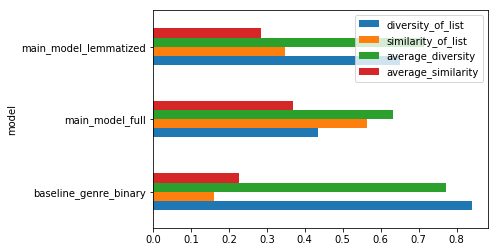

In [72]:
import matplotlib.pyplot as plt
combined_result_df.groupby('model').mean().plot(kind='barh')
plt.show()

In [18]:
recommendations = [1,2,3,4,5]
user_ids = [10, 11]

user_recommendations_df = pd.DataFrame()
user_recommendations_df.index.name = 'user_id'

In [19]:
for user in user_ids:
    user_rec_series = pd.Series(recommendations)
    user_rec_series.name = user
    
    user_recommendations_df = user_recommendations_df.append(user_rec_series)
    
user_recommendations_df

,0,1,2,3,4
user_id,,,,,
10,1.0,2.0,3.0,4.0,5.0
11,1.0,2.0,3.0,4.0,5.0
